# Train a spec2vec model on mass spectra dataset

In [1]:
import os
import sys
import gensim
import numpy as np
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
sys.path.insert(0, ROOT)

### Import pre-processed dataset "Unique InchiKeys"

In [2]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_unique_inchikey_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 13717


In [3]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

In [4]:
print("Maximum number of peaks in one spectrum:", np.max(number_of_peaks))
print("Number of spectra with > 1000 peaks:", np.sum(np.array(number_of_peaks)>1000))
print("Number of spectra with > 2000 peaks:", np.sum(np.array(number_of_peaks)>2000))
print("Number of spectra with > 5000 peaks:", np.sum(np.array(number_of_peaks)>5000))
print("Careful: Number of spectra with < 10 peaks:", np.sum(np.array(number_of_peaks)<10))

Maximum number of peaks in one spectrum: 361421
Number of spectra with > 1000 peaks: 2698
Number of spectra with > 2000 peaks: 1440
Number of spectra with > 5000 peaks: 485
Careful: Number of spectra with < 10 peaks: 908


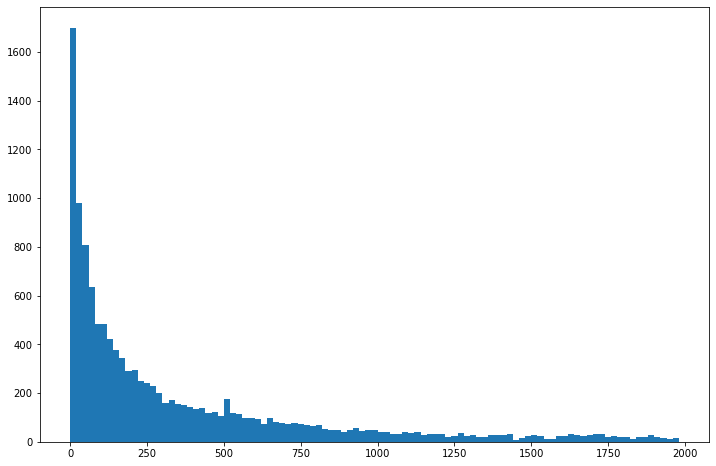

In [5]:
plt.figure(figsize=(12,8))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))

### Post-process spectra - Step 1
+ Normalize spectrum
+ Remove peaks outside m/z ratios between 0 and 1000.0
+ Discard spectra with less then 10 remaining peaks

In [6]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

In [7]:
def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    return s

# apply post processing steps to the data
spectrums = [post_process(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums if s is not None]

In [8]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

print("Maximum number of peaks in one spectrum:", np.max(number_of_peaks))
print("Number of spectra with > 1000 peaks:", np.sum(np.array(number_of_peaks)>1000))
print("Number of spectra with > 2000 peaks:", np.sum(np.array(number_of_peaks)>2000))
print("Number of spectra with > 5000 peaks:", np.sum(np.array(number_of_peaks)>5000))
print("Careful: Number of spectra with < 10 peaks:", np.sum(np.array(number_of_peaks)<10))

Maximum number of peaks in one spectrum: 228989
Number of spectra with > 1000 peaks: 2497
Number of spectra with > 2000 peaks: 1222
Number of spectra with > 5000 peaks: 335
Careful: Number of spectra with < 10 peaks: 0


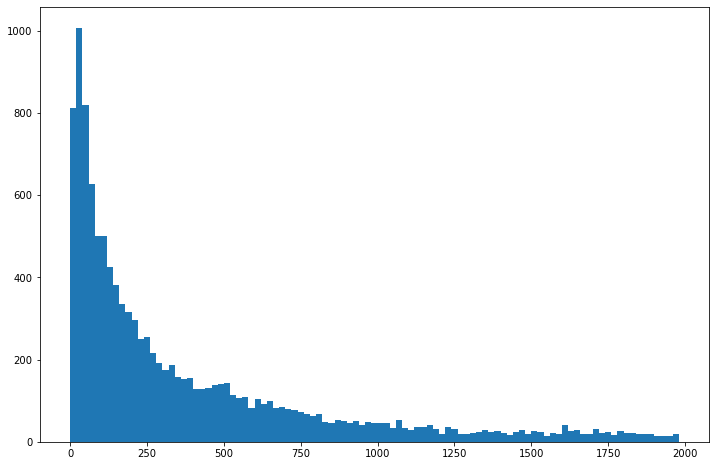

In [9]:
plt.figure(figsize=(12,8))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))

### Post-process spectra - step 2
+ Reduce number of peaks (scaled with parent-mass).

In [10]:
def post_process_step2(s):
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    return s

# apply post processing steps to the data
spectrums = [post_process_step2(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums if s is not None]

In [11]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

print("Maximum number of peaks in one spectrum:", np.max(number_of_peaks))
print("Number of spectra with > 1000 peaks:", np.sum(np.array(number_of_peaks)>1000))
print("Number of spectra with > 2000 peaks:", np.sum(np.array(number_of_peaks)>2000))
print("Number of spectra with > 5000 peaks:", np.sum(np.array(number_of_peaks)>5000))

Maximum number of peaks in one spectrum: 1001
Number of spectra with > 1000 peaks: 1
Number of spectra with > 2000 peaks: 0
Number of spectra with > 5000 peaks: 0


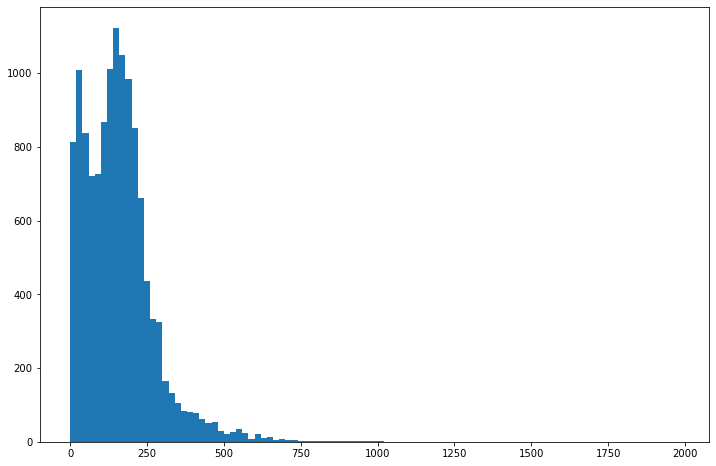

In [12]:
plt.figure(figsize=(12,8))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))

### Remove small peaks (<0.001 rel. intensity) if at least 10 peaks would remain

In [13]:
spectrums_postprocessed = []
for spec in spectrums:
    s = select_by_relative_intensity(spec, intensity_from=0.001)
    if len(s.peaks) >= 10:
        spectrums_postprocessed.append(s)
    else:
        spectrums_postprocessed.append(spec.clone())

In [14]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_postprocessed]

print("Maximum number of peaks in one spectrum:", np.max(number_of_peaks))
print("Number of spectra with > 1000 peaks:", np.sum(np.array(number_of_peaks)>1000))
print("Number of spectra with > 2000 peaks:", np.sum(np.array(number_of_peaks)>2000))
print("Number of spectra with > 5000 peaks:", np.sum(np.array(number_of_peaks)>5000))
print("Careful: Number of spectra with < 10 peaks:", np.sum(np.array(number_of_peaks)<10))

Maximum number of peaks in one spectrum: 1001
Number of spectra with > 1000 peaks: 1
Number of spectra with > 2000 peaks: 0
Number of spectra with > 5000 peaks: 0
Careful: Number of spectra with < 10 peaks: 0


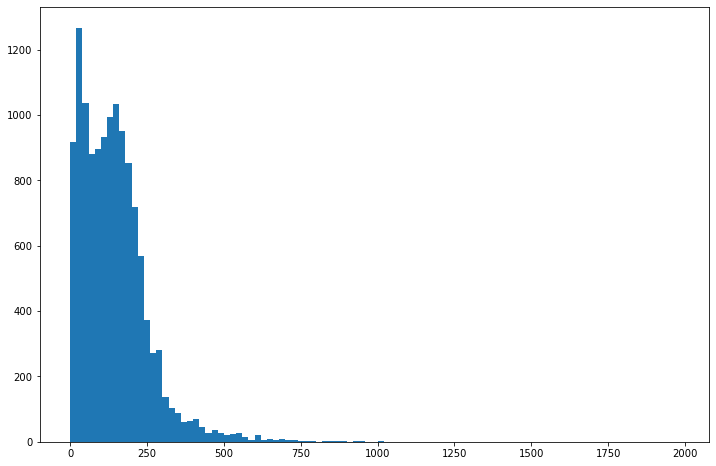

In [15]:
plt.figure(figsize=(12,8))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))

## Add neutral losses (within 0 to 200 m/z)

In [16]:
spectrums_postprocessed = [add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0) for s in spectrums_postprocessed]

# Convert spectra to document and train spec2vec model

In [17]:
from spec2vec import Spec2VecParallel
from spec2vec import SpectrumDocument

In [18]:
documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums_postprocessed]

In [19]:
documents[0].words

['peak@289.29',
 'peak@295.55',
 'peak@298.49',
 'peak@317.32',
 'peak@319.66',
 'peak@324.48',
 'peak@325.32',
 'peak@339.79',
 'peak@343.95',
 'peak@347.02',
 'peak@347.91',
 'peak@361.15',
 'peak@361.84',
 'peak@364.23',
 'peak@364.86',
 'peak@365.85',
 'peak@368.22',
 'peak@368.97',
 'peak@375.07',
 'peak@375.75',
 'peak@382.75',
 'peak@384.20',
 'peak@390.57',
 'peak@394.05',
 'peak@397.11',
 'peak@404.42',
 'peak@411.09',
 'peak@413.78',
 'peak@427.67',
 'peak@436.19',
 'peak@443.27',
 'peak@446.27',
 'peak@447.75',
 'peak@455.25',
 'peak@456.11',
 'peak@457.54',
 'peak@464.29',
 'peak@469.87',
 'peak@471.06',
 'peak@475.26',
 'peak@476.14',
 'peak@476.98',
 'peak@478.89',
 'peak@479.98',
 'peak@483.24',
 'peak@487.21',
 'peak@488.16',
 'peak@491.19',
 'peak@494.28',
 'peak@495.65',
 'peak@498.41',
 'peak@503.03',
 'peak@504.34',
 'peak@505.15',
 'peak@510.18',
 'peak@512.17',
 'peak@513.27',
 'peak@514.96',
 'peak@515.92',
 'peak@520.97',
 'peak@521.82',
 'peak@523.17',
 'peak@5

In [20]:
from custom_functions.utils_spec2vec import EpochLogger, ModelSaver

path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_UniqueInchikeys_ratio05_filtered.model")

# create and train model
learning_rate_initial = 0.025
learning_rate_decay = 0.00025
iterations = [1, 4, 5, 5, 5, 5, 5]
num_of_epochs = np.sum(iterations)

min_alpha = learning_rate_initial - num_of_epochs * learning_rate_decay
if min_alpha < 0:
    print("Warning! Number of iterations is too high for specified learning_rate decay.")
    print("Learning_rate_decay will be set from",
          learning_rate_decay, "to",
          learning_rate_initial/num_of_epochs)
    min_alpha = 0

epochlogger = EpochLogger(num_of_epochs)
modelsaver = ModelSaver(num_of_epochs, iterations, model_file)
model = gensim.models.Word2Vec([d.words for d in documents], sg=0, negative=5,
                               size=300, window=500, min_count=1, workers=4,
                               iter=num_of_epochs, alpha=learning_rate_initial,
                               min_alpha=min_alpha, seed=321, compute_loss=True,
                               callbacks = [epochlogger, modelsaver])

  Epoch 1 of 30.Change in loss after epoch 1: 1722169.125
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_UniqueInchikeys_ratio05_filtered_iter_1.model
  Epoch 2 of 30.Change in loss after epoch 2: 1336853.875
  Epoch 3 of 30.Change in loss after epoch 3: 1212687.5
  Epoch 4 of 30.Change in loss after epoch 4: 1090572.0
  Epoch 5 of 30.Change in loss after epoch 5: 1049326.5
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_UniqueInchikeys_ratio05_filtered_iter_5.model
  Epoch 6 of 30.Change in loss after epoch 6: 1032248.0
  Epoch 7 of 30.Change in loss after epoch 7: 994293.0
  Epoch 8 of 30.Change in loss after epoch 8: 857002.0
  Epoch 9 of 30.Change in loss after epoch 9: 841451.0
  Epoch 10 of 30.Change in loss after epoch 10: 834496.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOM